In [17]:
import numpy as np

In [23]:
x = torch.zeros(6, 6)
x[:3, :3] = torch.eye(3)
x

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [26]:
px, py = np.where(x==x.max())

In [27]:
px

array([0, 1, 2])

In [20]:
np.eye(6)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [18]:
x = np.zeros([10, 1])

In [19]:
x[0]

array([0.])

In [1]:
import torch

In [14]:
adj = torch.rand([3, 6, 6])

In [15]:
n = torch.tensor([0, 1, 2, 1, 2])

In [16]:
adj[n]

tensor([[[0.4837, 0.3565, 0.0156, 0.7746, 0.5161, 0.6821],
         [0.3805, 0.3138, 0.5487, 0.5406, 0.0195, 0.6926],
         [0.0343, 0.8129, 0.2193, 0.7352, 0.5347, 0.6568],
         [0.8064, 0.7008, 0.8004, 0.2045, 0.7831, 0.8990],
         [0.6032, 0.0905, 0.7128, 0.1098, 0.4989, 0.7644],
         [0.5981, 0.2866, 0.6328, 0.8644, 0.3129, 0.4610]],

        [[0.7125, 0.2713, 0.7206, 0.2238, 0.7239, 0.8111],
         [0.7241, 0.2444, 0.6763, 0.6520, 0.6885, 0.2843],
         [0.8325, 0.5157, 0.7919, 0.6453, 0.6794, 0.3440],
         [0.6064, 0.2522, 0.6332, 0.3891, 0.6959, 0.9544],
         [0.8017, 0.6308, 0.9765, 0.6074, 0.0486, 0.6188],
         [0.4861, 0.7497, 0.9173, 0.8172, 0.5503, 0.9492]],

        [[0.5536, 0.1836, 0.8902, 0.9216, 0.5379, 0.3801],
         [0.0650, 0.0831, 0.8162, 0.6112, 0.8823, 0.8738],
         [0.6763, 0.9252, 0.7871, 0.2791, 0.7544, 0.9244],
         [0.4339, 0.1111, 0.8045, 0.5234, 0.4312, 0.0296],
         [0.5612, 0.7743, 0.7200, 0.4374, 0.2666, 0.

In [ ]:
torch.cat(adj)

In [1]:
import sys
sys.path.append('../../ur5_mujoco')

In [2]:
from object_env import *

In [3]:
env = UR5Env(render=False, camera_height=480, camera_width=480, control_freq=5, data_format='NHWC', xml_ver=0)
env = objectwise_env(env, num_blocks=3, mov_dist=0.08, detection=True)

Creating window glfw


In [4]:
state = env.reset()

In [5]:
state[0].shape

(480, 480, 3)

In [6]:
state[1].shape

(480, 480, 3)

In [7]:
from sdf_module import *

In [8]:
sdf = SDFModule()

/home/gun/Desktop/ur5_manipulation/object_wise/dqn/../../UnseenObjectClustering/fcn/config.py:439: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


model keys
conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.bn1.running_mean
layer1.2.bn1.running_var
layer1.2.bn1.num_batches_tracked
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.bn2.running_mean
layer1.2.bn2.running_var
layer1.2.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.

In [8]:
st = time.time()
s0, (r0, f0) = sdf.get_sdf_features(state[0])
sg, (rg, fg) = sdf.get_sdf_features(state[1])
et = time.time()
print(et-st)

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/torch/nn/functional.py:2589: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


ValueError: too many values to unpack (expected 2)

In [10]:
st = time.time()
_ = sdf.get_masks(state[0])
_ = sdf.get_masks(state[1])
et = time.time()
print(et-st)

0.3435251712799072


In [21]:
st = time.time()
image = state[0]
# image = image.transpose([2, 0, 1])

im_tensor = torch.from_numpy(image).type(torch.float32).permute(2, 0, 1).unsqueeze(0).cuda()
features = sdf.network(im_tensor, None).detach()
out_label, selected_pixels = clustering_features(features, num_seeds=100)

et = time.time()
print(et-st)

0.15015101432800293


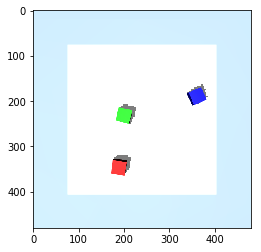

In [12]:
plt.imshow(state[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


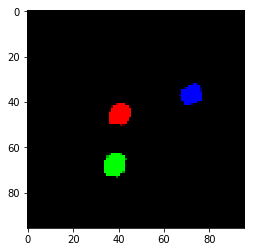

In [13]:
plt.imshow(s0.transpose([1,2,0]))

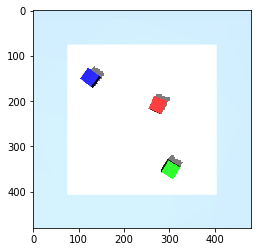

In [14]:
plt.imshow(state[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


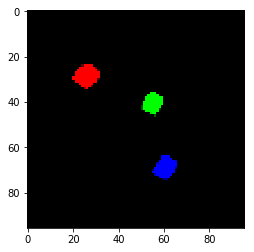

In [15]:
plt.imshow(sg[:3].transpose([1,2,0]))

In [16]:
np.array(f0).dot(np.array(fg).T)

array([[ 2.8219196e-01,  2.5478610e-01, -9.6765935e-02],
       [-2.6748586e-02, -1.1365465e-01,  3.9999077e-01],
       [ 2.7088821e-04,  5.2567434e-01, -1.9726381e-02]], dtype=float32)

In [17]:
xn = f0 / np.linalg.norm(f0, axis=1).reshape(3, 1)
yn = fg / np.linalg.norm(fg, axis=1).reshape(3, 1)

In [18]:
xn.dot(yn.T)

array([[ 3.0446315e-01,  2.7491707e-01, -1.0439561e-01],
       [-2.8659426e-02, -1.2178399e-01,  4.2853534e-01],
       [ 2.9028580e-04,  5.6337273e-01, -2.1137826e-02]], dtype=float32)

In [19]:
xn.dot(yn.T).argmax(1)

array([0, 2, 1])

In [20]:
r0n = r0 / np.linalg.norm(r0, axis=1).reshape(3, 1)
rgn = rg / np.linalg.norm(rg, axis=1).reshape(3, 1)

In [21]:
r0n.dot(rgn.T)

array([[0.90995183, 0.89605821, 0.9983021 ],
       [0.90698796, 0.99928713, 0.88806753],
       [0.99574963, 0.85417046, 0.84884378]])

In [22]:
r0n.dot(rgn.T).argmax(1)

array([2, 1, 0])

In [23]:
new0 = np.concatenate([r0, f0], axis=1)
newg = np.concatenate([rg, fg], axis=1)

In [24]:
new0n = new0 / np.linalg.norm(new0, axis=1).reshape(3, 1)
newgn = newg / np.linalg.norm(newg, axis=1).reshape(3, 1)

In [25]:
new0n.dot(newgn.T)

array([[0.65731094, 0.63809326, 0.5212285 ],
       [0.50072723, 0.51461945, 0.68156287],
       [0.56184808, 0.72777208, 0.4565355 ]])

In [26]:
new0n.dot(newgn.T).argmax(1)

array([0, 2, 1])

In [27]:
idx = new0n.dot(newgn.T).argmax(1)
new0n.dot(newgn[idx].T).argmax(1)

array([0, 1, 2])

In [28]:
ss, sg = sdf.get_aligned_sdfs(state[0], state[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


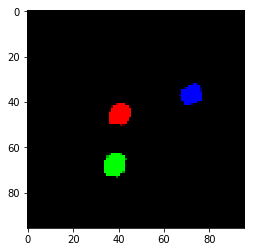

In [29]:
plt.imshow(ss.transpose([1,2,0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


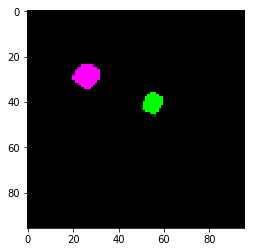

In [30]:
plt.imshow(sg.transpose([1,2,0]))

In [37]:
import cv2

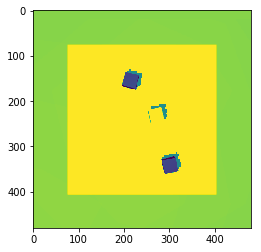

In [44]:
plt.imshow(state[0][:,:,0])

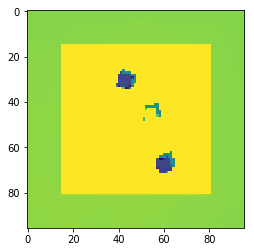

In [45]:
x = cv2.resize(state[0][:,:,0], (96, 96))
plt.imshow(x)

In [48]:
x.shape

(96, 96)

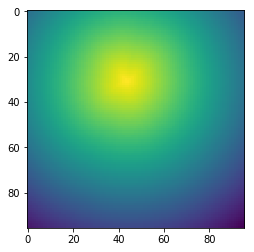

In [50]:
x = cv2.resize(s0[0], (96, 96))
plt.imshow(x)

In [46]:
s0.shape

(3, 480, 480)

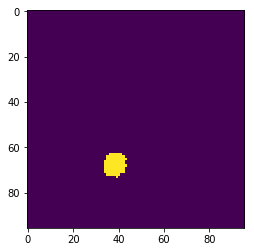

In [44]:
plt.imshow(s0[1]>0)

In [45]:
[px], [py] = np.where(s0[1]==s0[1].max())

In [46]:
px, py

(68, 38)

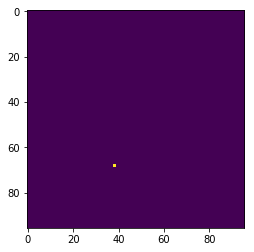

In [47]:
z = np.zeros([96, 96])
z[px, py] = 1
plt.imshow(z)

In [2]:
import numpy as np

In [35]:
x = np.random.random([4, 5])
y = np.random.random([3, 5])

In [36]:
x

array([[0.32760297, 0.0727951 , 0.18478654, 0.32826542, 0.42338854],
       [0.80688885, 0.31765814, 0.46727169, 0.88493521, 0.08802706],
       [0.35412284, 0.40088037, 0.57078666, 0.07389149, 0.65739878],
       [0.88349289, 0.80072712, 0.42438855, 0.89977359, 0.27898198]])

In [37]:
y

array([[0.06244564, 0.29301556, 0.06735517, 0.69928376, 0.60767946],
       [0.59664235, 0.22515784, 0.49826215, 0.71546733, 0.57226945],
       [0.12389847, 0.39324521, 0.64589465, 0.07616206, 0.93208619]])

In [38]:
x.dot(y.T)

array([[0.541069  , 0.78107985, 0.60820445],
       [0.84725169, 1.46928851, 0.67614541],
       [0.62918191, 1.01502362, 1.18856766],
       [1.11710923, 1.72228749, 1.02701967]])

In [39]:
x.dot(y.T).argmax(1)

array([1, 1, 2, 1])

In [40]:
x.dot(y.T).argmax(0)

array([3, 3, 2])

In [41]:
x[x.dot(y.T).argmax(0)]

array([[0.88349289, 0.80072712, 0.42438855, 0.89977359, 0.27898198],
       [0.88349289, 0.80072712, 0.42438855, 0.89977359, 0.27898198],
       [0.35412284, 0.40088037, 0.57078666, 0.07389149, 0.65739878]])

In [63]:
xn = x / np.linalg.norm(x, axis=1).reshape(4, 1)
yn = y / np.linalg.norm(y, axis=1).reshape(3, 1)

In [64]:
xn.dot(yn.T)

array([[0.68603269, 0.89357979, 0.79795091],
       [0.66681712, 0.76665397, 0.7141124 ],
       [0.67188906, 0.72310934, 0.73731868],
       [0.68371166, 0.83301717, 0.91036777]])

In [65]:
xn.dot(yn.T).argmax(1)

array([1, 1, 2, 2])